Cloning into 'DeOldify'...
remote: Enumerating objects: 2620, done.
remote: Counting objects: 100% (274/274), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 2620 (delta 93), reused 212 (delta 73), pack-reused 2346 (from 1)
Receiving objects: 100% (2620/2620), 69.71 MiB | 25.89 MiB/s, done.
Resolving deltas: 100% (1176/1176), done.
/content/DeOldify/DeOldify/DeOldify/DeOldify/DeOldify/DeOldify/DeOldify/DeOldify/DeOldify/DeOldify/DeOldify/DeOldify/DeOldify
mkdir: cannot create directory ‘models’: File exists
--2024-11-11 05:44:35--  https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth
Resolving data.deepai.org (data.deepai.org)... 185.93.1.251, 2400:52e0:1a00::1069:1
Connecting to data.deepai.org (data.deepai.org)|185.93.1.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255144681 (243M) [application/octet-stream]
Saving to: ‘./models/ColorizeArtistic_gen.pth’

./models/ColorizeAr 100%[===================>] 243.32M  4.86MB/s    in

Saving test2.jpg to test2.jpg


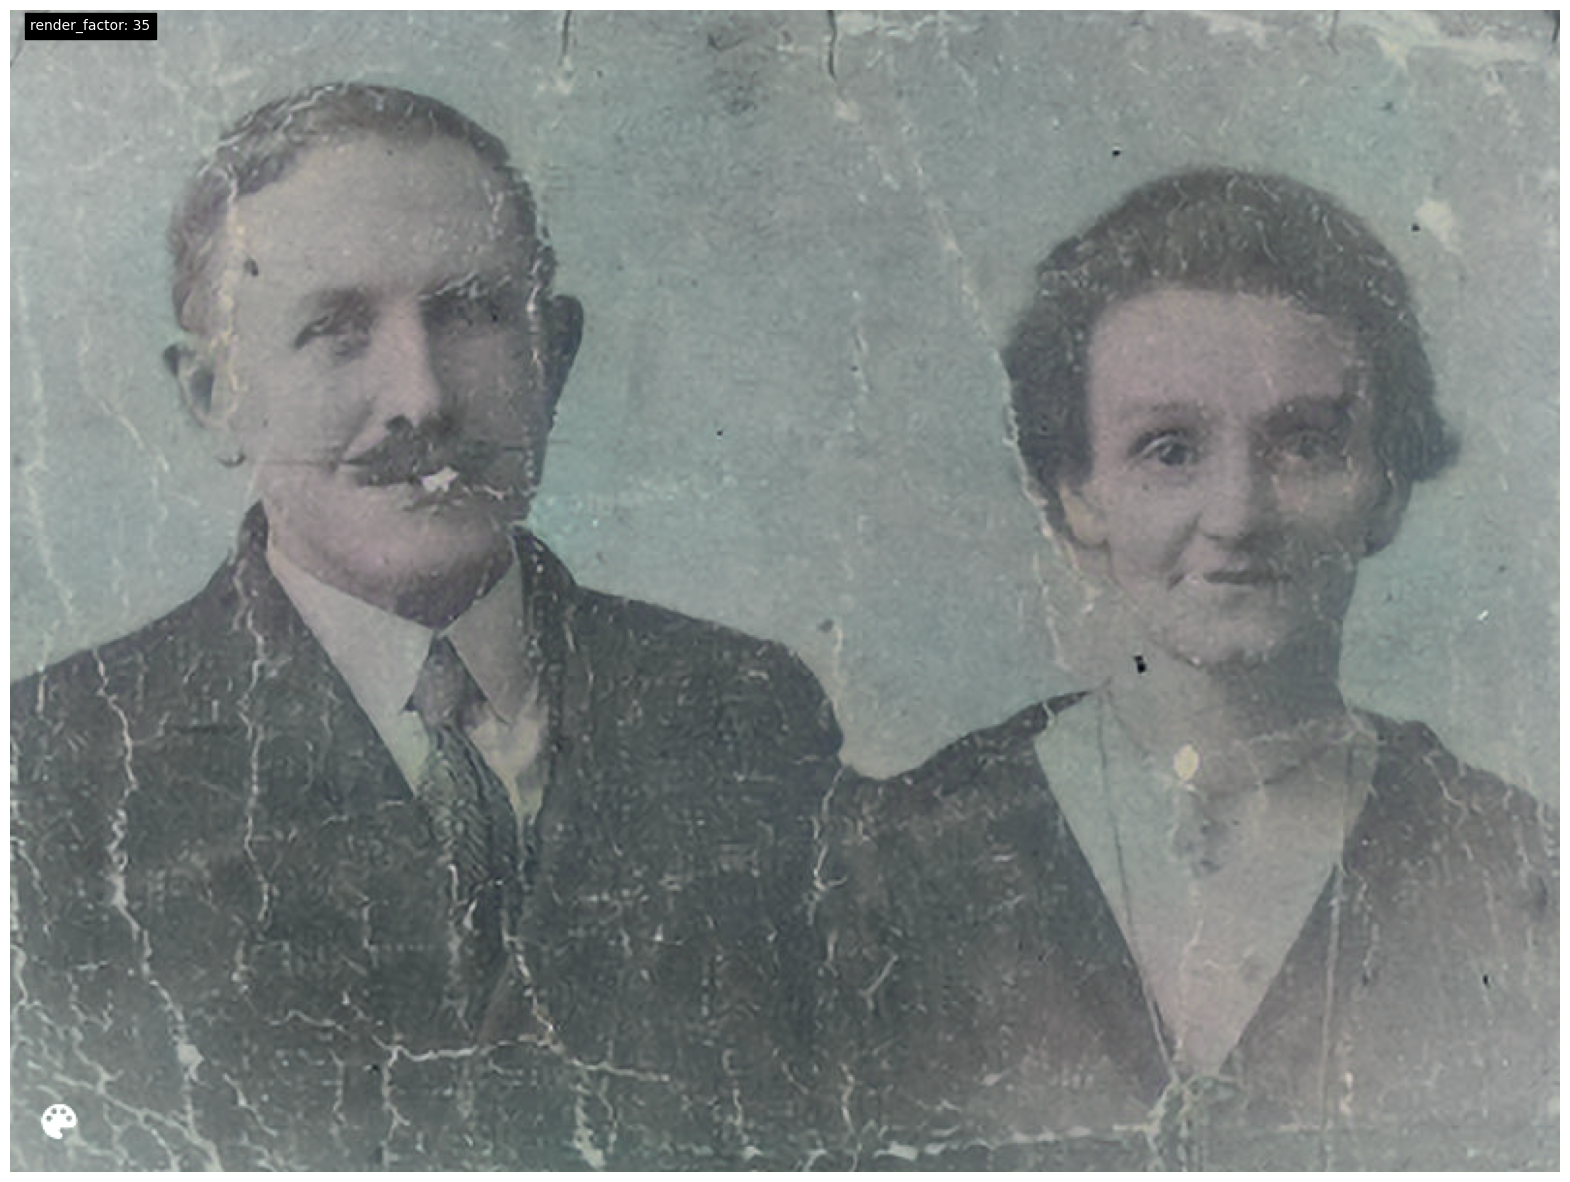

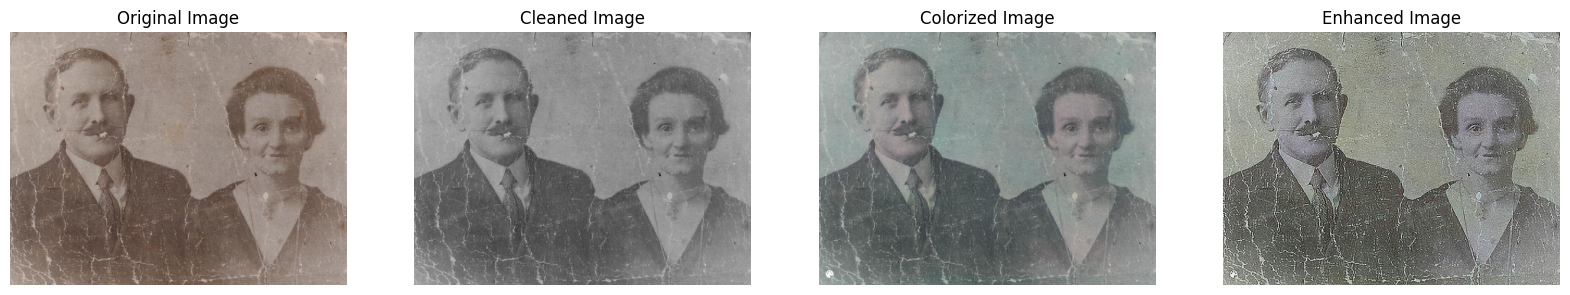

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# Step 1: Clone the DeOldify repository and navigate into it
!git clone https://github.com/jantic/DeOldify.git DeOldify
%cd DeOldify

# Step 2: Install required packages and ffmpeg
!pip install -r requirements-colab.txt
!pip install ffmpeg-python opencv-python-headless

# Step 3: Download the model weights
!mkdir 'models'
!wget https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth -O ./models/ColorizeArtistic_gen.pth

# Step 4: Update sys.path to ensure Colab can find the DeOldify code
import sys
sys.path.append('/content/DeOldify')

# Step 5: Import and set up DeOldify
from deoldify.visualize import *
import torch

# Set device to GPU if available
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Initialize the colorizer with the Artistic model
colorizer = get_image_colorizer(artistic=True)

# Step 6: Upload an Image
from google.colab import files
uploaded = files.upload()

# Get the file name of the uploaded image
input_path = list(uploaded.keys())[0]

# Step 7: Preprocess the Image to Remove Lines/Scratches
import cv2
import numpy as np
from PIL import Image as PILImage

# Load the original image
original_image_cv = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

# Apply inpainting to remove scratches/lines
# 1. Detect lines/scratches (assumes scratches are light lines on dark backgrounds)
_, thresh = cv2.threshold(original_image_cv, 240, 255, cv2.THRESH_BINARY_INV)
inpaint_mask = cv2.dilate(thresh, None, iterations=2)

# 2. Inpaint to remove lines
cleaned_image = cv2.inpaint(original_image_cv, inpaint_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

# Convert back to a color image
cleaned_image_color = cv2.cvtColor(cleaned_image, cv2.COLOR_GRAY2RGB)

# Step 8: Save the Cleaned Image and Load it with DeOldify for Colorization
cleaned_image_path = "/content/cleaned_image.jpg"
cv2.imwrite(cleaned_image_path, cleaned_image_color)

# Step 9: Colorize the Cleaned Image
render_factor = 35  # Adjust render factor for desired quality
result_path = colorizer.plot_transformed_image(path=cleaned_image_path, render_factor=render_factor, display_render_factor=True, figsize=(20,20))

# Step 10: Enhance the Colorized Image
# Load the colorized image
colorized_image = PILImage.open(result_path)

# Convert image to OpenCV format (numpy array) for enhancement
colorized_image_cv = cv2.cvtColor(np.array(colorized_image), cv2.COLOR_RGB2BGR)

# Apply sharpening (using a kernel)
sharpen_kernel = np.array([[-1, -1, -1], [-1,  9, -1], [-1, -1, -1]])  # Simple sharpening kernel
sharpened_image = cv2.filter2D(colorized_image_cv, -1, sharpen_kernel)

# Convert back to RGB for display and saving
enhanced_image = cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB)

# Save the enhanced image
enhanced_result_path = "/content/enhanced_image.jpg"
cv2.imwrite(enhanced_result_path, enhanced_image)

# Step 11: Display the Original, Cleaned, Colorized, and Enhanced Images
import matplotlib.pyplot as plt

# Load the original image
original_image = PILImage.open(input_path)

# Plot the images
plt.figure(figsize=(20, 8))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Cleaned Image
cleaned_image_pil = PILImage.fromarray(cv2.cvtColor(cleaned_image_color, cv2.COLOR_BGR2RGB))
plt.subplot(1, 4, 2)
plt.imshow(cleaned_image_pil)
plt.title("Cleaned Image")
plt.axis('off')

# Colorized Image
colorized_image = PILImage.open(result_path)
plt.subplot(1, 4, 3)
plt.imshow(colorized_image)
plt.title("Colorized Image")
plt.axis('off')

# Enhanced Image
enhanced_image_pil = PILImage.open(enhanced_result_path)
plt.subplot(1, 4, 4)
plt.imshow(enhanced_image_pil)
plt.title("Enhanced Image")
plt.axis('off')

plt.show()

# Step 12: Download the Enhanced Image
files.download(enhanced_result_path)
